In [ ]:
# default_exp data
%load_ext lab_black
# nb_black if running in jupyter
%load_ext autoreload
# automatically reload python modules if there are changes in the
%autoreload 2

In [ ]:
# hide
from nbdev.showdoc import *

# Data

> (Generate*), load and clean data

*to avoid privacy issues we generate new data, similar to real client data we have. You may replace this with customer path data of your own. 

***input***: raw data

***output***: clean and tidy dataset + toy dataset for testing

***description:***

In this notebook we generate customer path data, and transform it into tensorflow federated [ClientData](https://www.tensorflow.org/federated/tutorials/working_with_client_data) format.
You can edit the code to load and clean and transform your own client path data.

## Import relevant modules

In [ ]:
# tensorflow_federated_nightly also bring in tf_nightly, which
# can causes a duplicate tensorboard install, leading to errors.
#!pip uninstall --yes tensorboard tb-nightly

#!pip install --quiet --upgrade tensorflow-federated-nightly
#!pip install --quiet --upgrade nest-asyncio
#!pip install --quiet --upgrade tb-nightly  # or tensorboard, but not both

In [ ]:
# export
import nest_asyncio

nest_asyncio.apply()
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff

In [ ]:
from pyarrow import feather
from scipy.special import softmax
from seaborn import heatmap

## Define notebook parameters

Define input, output and additional parameters of this notebook, the information needed for running the notebook.
In your own project, you can do this step in the later iterations of the work,
when you know what is required.
In this cell, only assing values to variables directly: `variable_name = value`.
**Do not derive any information in this cell as it will mess up the parameterization** - do it in the cell below.

In [ ]:
# This cell is tagged with 'parameters'
seed = 0

SHUFFLE_BUFFER = 1000
NUM_EPOCHS = 1

n_customers = 10000  # number of customers (paths, assuming only one path per customer)
max_path_length = 100  # limit simulation length

Define any immediate derivative operations from the parameters:

In [ ]:
# set seed
np.random.seed(seed)
# your code here

## Generate data (from a Markov Process)

Our decired data point is a transition between two customer sevice states for a customer.
The feature is the previous service state, and the label is the following service state.

We need to simulate imaginary customer paths trough markov process modelling.

In our example we have one incoming state 'begin', and one absorbing state 'end'.
The customer is in the beginning state before the first service event.
In the between there are X service states that the customer can encounter.
After the last observed service state the customer is moved to 'end' state. 
You are free to apply different assumptions.

For example we could include information on the incoming state: is it the frontpage of the service, another website, social media etc. 

In [ ]:
# state space
S = np.array(
    [
        "begin",
        "search",
        "scrolling",
        "view",
        "chatbot",
        "customer_service",
        "shopping_cart",
        "purchace",
        "end",
    ]
)
n_states = S.shape[0]

# transition matrix
# the actual values of the transition matrix do not matter, so we just generate random.
# the ML algorithms should be able to learn whatever relations
P = np.hstack(
    (
        np.zeros((n_states, 1)),  # cannot reach begin state afterwards
        softmax(np.random.uniform(size=(n_states, n_states - 1)), axis=1),
    )
)  # randomly set other transition states
P[-1, :] = 0
P[-1, -1] = 1  # the absorbing state

assert np.count_nonzero(P.sum(axis=0) - 1) == n_states

Text(0.5, 1.0, 'Transition matrix')

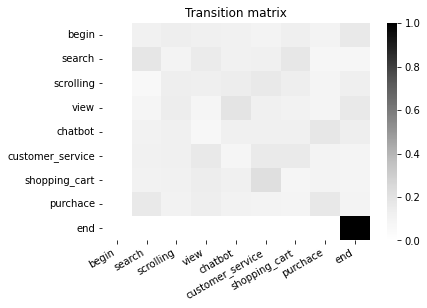

In [ ]:
g = heatmap(P, cmap="Greys")
g.set_yticklabels(S, rotation=0)
g.set_xticklabels(S, rotation=30, va="top", ha="right")
g.set_title("Transition matrix")

Then, let's generate some customer paths

In [ ]:
# dataframe to store the results
df = pd.DataFrame(
    columns={"customer_id": int, "prev_state": np.uint8, "next_state": np.uint8}
)

# loop through customers
for customer_id in range(n_customers):
    prev_state = 0
    count = 0
    while prev_state != n_states - 1 and count < max_path_length:
        # select new state according to weights in transition matrix
        next_state = np.random.choice(np.arange(n_states), p=P[prev_state, :].flatten())
        df = df.append(
            {
                "customer_id": customer_id,
                "prev_state": prev_state,
                "next_state": next_state,
            },
            ignore_index=True,
        )
        prev_state = next_state
        count += 1

# check out results
df.head()

,customer_id,prev_state,next_state
0,0,0,8
1,1,0,6
2,1,6,6
3,1,6,1
4,1,1,2


## Visualize the data

plot histogram of path lengths

with one absorbing state, should decay exponentially: $y=e^{-ax+b}$

<AxesSubplot:>

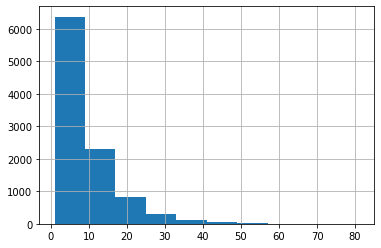

In [ ]:
df.groupby("customer_id").count()["prev_state"].hist()

## Convert dataframe state variables into one hot encoding

In [ ]:
onehot_df = pd.DataFrame(data=df.customer_id.values, columns={"client_id": int})

# we have to make an untidy nested structure for tff ClientData
onehot_df["x"] = pd.get_dummies(df.prev_state, prefix="x").apply(
    lambda row: row.to_numpy(), axis=1
)  # we could also include more features, for example the order and date information of the meeting

# ok but for labels we can not have one-hot :D
# https://stackoverflow.com/questions/49083984/valueerror-can-not-squeeze-dim1-expected-a-dimension-of-1-got-3-for-sparse
onehot_df[
    "y"
] = (
    df.next_state
)  # pd.get_dummies(df.next_state, prefix="y").apply(lambda row: row.to_numpy(), axis=1)
onehot_df

,client_id,x,y
0,0,"[1, 0, 0, 0, 0, 0, 0, 0]",8
1,1,"[1, 0, 0, 0, 0, 0, 0, 0]",6
2,1,"[0, 0, 0, 0, 0, 0, 1, 0]",6
3,1,"[0, 0, 0, 0, 0, 0, 1, 0]",1
4,1,"[0, 1, 0, 0, 0, 0, 0, 0]",2
...,...,...,...
83637,9999,"[0, 1, 0, 0, 0, 0, 0, 0]",1
83638,9999,"[0, 1, 0, 0, 0, 0, 0, 0]",4
83639,9999,"[0, 0, 0, 0, 1, 0, 0, 0]",3
83640,9999,"[0, 0, 0, 1, 0, 0, 0, 0]",1


## (or alternatively load your own data and turn it into the same format)

In [ ]:
# your code here

## Save data

In [ ]:
feather.write_feather(onehot_df, "data/preprocessed_data/data.f")

## Create function to convert df into tff ClientData

Following this discussion: https://stackoverflow.com/questions/58965488/how-to-create-federated-dataset-from-a-csv-file

> **NOTE**: here term 'customer' changes to 'client'

In [ ]:
# export

import collections


def create_tff_client_data_from_df(
    df,
    client_id_col="client_id",
    sample_size=1.0,
    shuffle_buffer=100,
    batch_size=20,
    num_epochs=5,
    prefetch_buffer=10,
):
    """
    turn pd dataframe into tff client datasets (train and test datasets)
    """

    def batch_format_fn(element):
        """should have only flat vectors, reshape if needed"""
        return collections.OrderedDict(
            x=element["x"],  # tf.reshape(element[xcol], [-1, xshape]),
            y=element["y"],  # tf.reshape(element[ycol], [-1, yshape]),
        )

    def create_tf_dataset_for_client_fn(client_id):
        """a function which takes a client_id and returns a tf.data.Dataset for that client"""
        client_data = df[df.client_id == client_id]
        dataset = tf.data.Dataset.from_tensor_slices(client_data.to_dict("list"))
        # dataset = dataset.shuffle(shuffle_buffer).batch(num_batch).repeat(num_epochs)
        dataset = (
            dataset.repeat(num_epochs)
            .shuffle(shuffle_buffer, seed=1)
            .batch(batch_size)
            .map(batch_format_fn)
            .prefetch(prefetch_buffer)
        )
        return dataset

    # split client id into train and test clients
    client_ids = np.random.choice(
        df[client_id_col].unique(),
        size=int(sample_size * df[client_id_col].nunique()),
    ).tolist()  # proportion of clients to use

    # train data
    tff_data = tff.simulation.datasets.ClientData.from_clients_and_fn(
        client_ids=client_ids,
        create_tf_dataset_for_client_fn=create_tf_dataset_for_client_fn,
    )

    return tff_data

Test:

In [ ]:
tff_data = create_tff_client_data_from_df(onehot_df)

assert len(tff_data.client_ids) == onehot_df.client_id.unique().shape[0]

In [ ]:
train_data, test_data = tff.simulation.datasets.ClientData.train_test_client_split(
    tff_data, 500
)
assert len(train_data.client_ids) == onehot_df.client_id.nunique() - 500
assert len(test_data.client_ids) == 500